In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time

import matplotlib.pyplot as plt
import numpy as np
import proper

from paos.core.parseConfig import parse_config
from paos.core.run import run

In [3]:
def push_results(wfo, init=False):
    if init:
        fratio = proper.prop_get_fratio(wfo)
        retval = {'fratio': fratio if fratio < 1e9 else np.inf}
    else:
        fratio = proper.prop_get_fratio(wfo)
        retval = {'amplitude': proper.prop_get_amplitude(wfo),
                  'wz': proper.prop_get_beamradius(wfo),
                  'distancetofocus': proper.prop_get_distancetofocus(wfo),
                  'phase': proper.prop_get_phase(wfo),  # phase angles in proper are defined in the opposite sense
                  'dx': proper.prop_get_sampling(wfo),
                  'dy': proper.prop_get_sampling(wfo),
                  'wfo': proper.prop_get_wavefront(wfo),
                  'wl': proper.prop_get_wavelength(wfo),
                  'aperture': None,
                  'fratio': fratio if fratio < 1e9 else np.inf
                  }
    return retval

In [4]:
def hubble_simple(wl, gridsize, PASSVALUE=None):
    if PASSVALUE is None:
        PASSVALUE = {}
    proper.print_it = True

    start_time = time.time()

    # Define entrance aperture diameter and other quantities
    diam = 2.4  # telescope diameter in meters
    fl_pri = 5.52085  # HST primary focal length (m)
    d_pri_sec = 4.907028205  # primary to secondary separation (m)
    fl_sec = -0.6790325  # HST secondary focal length (m)
    d_sec_to_focus = 6.3919974  # nominal distance from secondary to focus
    beam_ratio = 0.25  # initial beam width/grid width

    # Define the wavefront
    wfo = proper.prop_begin(diam, wl, gridsize, beam_ratio)
    proper.prop_set_antialiasing(nsub=11)

    # Define a circular aperture
    proper.prop_circular_aperture(wfo, diam / 2)  # HST aperture (primary mirror)
    proper.prop_circular_obscuration(wfo, 0.396)  # secondary mirror obscuration
    proper.prop_rectangular_obscuration(wfo, 0.0264, 2.5)  # secondary vane (vertical)
    proper.prop_rectangular_obscuration(wfo, 2.5, 0.0264)  # secondary vane (horizontal)
    proper.prop_circular_obscuration(wfo, 0.078, -0.9066, -0.5538)  # primary mirror pad 1
    proper.prop_circular_obscuration(wfo, 0.078, 0., 1.0705)  # primary mirror pad 2
    proper.prop_circular_obscuration(wfo, 0.078, 0.9127, -0.5477)  # primary mirror pad 3

    # Define entrance
    proper.prop_define_entrance(wfo)

    # Define a lens
    PASSVALUE[0] = push_results(wfo, init=True)
    proper.prop_lens(wfo, fl_pri, "primary")  # primary mirror
    PASSVALUE[0].update(push_results(wfo))

    # Propagate the wavefront
    proper.prop_propagate(wfo, d_pri_sec, "secondary")

    PASSVALUE[1] = push_results(wfo)
    # retval['extent'] = extent(retval['wfo'], retval['dx'], retval['dy'])

    proper.prop_zernikes(wfo, [4, 5, 6], [0.1e-6, 0.1e-6, 0.1e-6])
    proper.prop_lens(wfo, fl_sec, "secondary")
    PASSVALUE[1].update(push_results(wfo))

    PASSVALUE[2] = push_results(wfo)
    proper.prop_propagate(wfo, d_sec_to_focus, "HST focus", TO_PLANE=False)
    PASSVALUE[2].update(push_results(wfo))

    # End
    (wfo, sampling) = proper.prop_end(wfo)

    end_time = time.time()

    if proper.print_it:
        print("Total elapsed time (seconds) = %8.4f" % (end_time - start_time))

    return PASSVALUE

# Hubble simple

## PAOS

In [5]:
pup_diameter, parameters, wavelengths, fields, opt_chains = parse_config('./Hubble_simple_aberrated.ini')
wavelength, opt_chain = wavelengths[0], opt_chains[0]
hubble_retval_paos = run(pup_diameter, 1.0e-6 * wavelength, parameters['grid_size'], parameters['zoom'], fields[0], opt_chain)
hubble_paos_key = list(hubble_retval_paos.keys())[-1]  # plot at last optical surface
hubble_paos_item = hubble_retval_paos[hubble_paos_key]

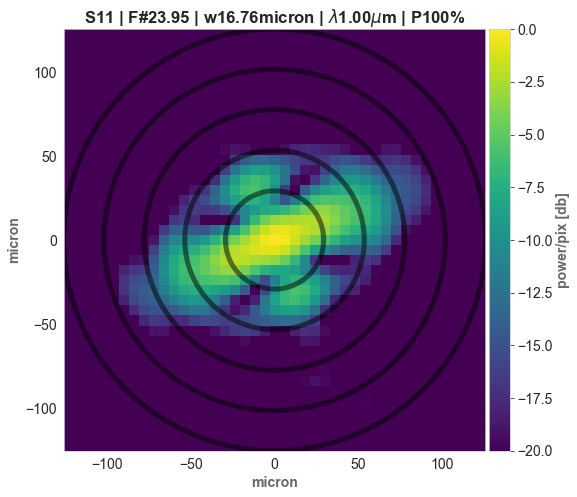

In [6]:
from paos.core.plot import simple_plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
simple_plot(fig, ax, key=hubble_paos_key, item=hubble_paos_item, ima_scale='log')
plt.show()

## Proper

In [7]:
hubble_retval_proper = hubble_simple(wl=1.0e-6, gridsize=1024, PASSVALUE={})
hubble_proper_key = list(hubble_retval_proper.keys())[-1]  # plot at last optical surface
hubble_proper_item = hubble_retval_proper[hubble_proper_key]

Applying lens at primary
Propagating to secondary
Applying aberrations
Applying lens at secondary
Propagating to HST focus
Total elapsed time (seconds) =   1.8843


# Plot

In [8]:
# plt.style.use('seaborn-talk')

In [9]:
from matplotlib.legend_handler import HandlerLine2D


def update_width(handle, orig, linewidth=1.5):
    handle.update_from(orig)
    handle.set_linewidth(linewidth)


def do_legend(ax, ncol=2, fontsize=8, framealpha=1, markerscale=1, handlelength=1.5):
    ax.legend(loc='lower center', ncol=ncol, fontsize=fontsize, framealpha=framealpha, markerscale=markerscale,
              # Make marker for line thicker
              handlelength=handlelength,
              handler_map={plt.Line2D: HandlerLine2D(update_func=update_width)}
              ).get_frame().set_facecolor('white')

# Use colorblind-friendly colors
import seaborn as sns
palette = sns.color_palette('colorblind')
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=palette)
# Make font normalweight
plt.rcParams['font.weight'] = 'normal'

In [10]:
hubble_paos_psf = hubble_paos_item['amplitude'] ** 2
# hubble_paos_psf = np.ones(hubble_paos_psf.shape)
hubble_proper_psf = hubble_proper_item['amplitude'] ** 2

hubble_paos_psf_dB = hubble_paos_psf / np.max(hubble_paos_psf)
hubble_proper_psf_dB = hubble_proper_psf / np.max(hubble_proper_psf)

hubble_paos_psf_dB = 10 * np.log10(hubble_paos_psf_dB)
hubble_proper_psf_dB = 10 * np.log10(hubble_proper_psf_dB)

In [11]:
# Do a single plot with only the hubbles psf

fig, axes = plt.subplots(2, 2, figsize=(10, 10 / 1.618), dpi=300)
axes = axes.flatten()

axes[0].plot(hubble_paos_psf_dB[512, :], alpha=0.7, lw=0.5, label='PAOS', color='C0')
axes[0].plot(hubble_proper_psf_dB[512, :], alpha=0.7, lw=0.5, label='PROPER', color='C1')
axes[0].set_title('Hubble PSF (x slice)', fontweight='normal')
axes[0].set_xlabel('x [pix]', fontweight='normal')
axes[0].set_ylabel('power/pix [dB]', fontweight='normal')
do_legend(axes[0])

axes[1].plot(hubble_proper_psf_dB[512, :] - hubble_paos_psf_dB[512, :], lw=0.5, label='PROPER - PAOS', color='C2')
axes[1].set_title('Difference', fontweight='normal')
axes[1].set_xlabel('x [pix]', fontweight='normal')
axes[1].set_ylabel('power/pix [dB]', fontweight='normal')
do_legend(axes[1])

axes[2].plot(hubble_paos_psf_dB[:, 512], alpha=0.7, lw=0.5, label='PAOS', color='C0')
axes[2].plot(hubble_proper_psf_dB[:, 512], alpha=0.7, lw=0.5, label='PROPER', color='C1')
axes[2].set_title('Hubble PSF (y slice)', fontweight='normal')
axes[2].set_xlabel('y [pix]', fontweight='normal')
axes[2].set_ylabel('power/pix [dB]', fontweight='normal')
do_legend(axes[2])

axes[3].plot(hubble_proper_psf_dB[:, 512] - hubble_paos_psf_dB[:, 512], lw=0.5, label='PROPER - PAOS', color='C2')
axes[3].set_title('Difference', fontweight='normal')
axes[3].set_xlabel('y [pix]', fontweight='normal')
axes[3].set_ylabel('power/pix [dB]', fontweight='normal')
do_legend(axes[3])

plt.tight_layout()
# plt.show()

plt.savefig('figures/hubble_psf_comparison_aberrated.pdf', bbox_inches='tight', dpi=300)
plt.close()

In [12]:
# Plot the psf for template and hubble, with PAOS and PROPER
from mpl_toolkits.axes_grid1 import make_axes_locatable

# use viridis colormap
plt.rcParams['image.cmap'] = 'viridis'
# normalweight labels
plt.rcParams['axes.labelweight'] = 'normal'

fig, axes = plt.subplots(1, 3, figsize=(12, 12 / 1.618), dpi=300)
axes = axes.flatten()

im3 = axes[0].imshow(hubble_paos_psf_dB, vmin=-60)
axes[0].set_title('HST PSF (PAOS)', fontweight='normal')
divider = make_axes_locatable(axes[0])
cax3 = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im3, cax=cax3, label='power/pix [dB]')

im4 = axes[1].imshow(hubble_proper_psf_dB, vmin=-60)
axes[1].set_title('HST PSF (PROPER)', fontweight='normal')
divider = make_axes_locatable(axes[1])
cax4 = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im4, cax=cax4, label='power/pix [dB]')

diff_db = hubble_proper_psf_dB - hubble_paos_psf_dB
# get percentiles for vmin and vmax using 0.27% and 99.73% percentiles
# take diff_db inside the window of 32 pixels centered on the center of the image
diff_db_window = diff_db[1024 // 2 - 32:1024 // 2 + 32, 1024 // 2 - 32:1024 // 2 + 32]
# vmin = np.percentile(diff_db_window, 0.27)
# vmax = np.percentile(diff_db_window, 99.73)
vmin = diff_db_window.min()
vmax = diff_db_window.max()
im5 = axes[2].imshow(hubble_proper_psf_dB - hubble_paos_psf_dB, vmin=vmin, vmax=vmax)
axes[2].set_title('PROPER - PAOS', fontweight='normal')
divider = make_axes_locatable(axes[2])
cax5 = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im5, cax=cax5, label='power/pix [dB]')

for ax in axes:
    ax.set_xlabel('x (pixels)')
    ax.set_ylabel('y (pixels)')
    ax.set_xlim([1024 // 2 - 32, 1024 // 2 + 32])
    ax.set_ylim([1024 // 2 - 32, 1024 // 2 + 32])
    # remove grid
    ax.grid(False)

plt.tight_layout()
# plt.show()

plt.savefig('figures/hubble_psf2d_comparison_aberrated.pdf', bbox_inches='tight', dpi=300)
plt.close()

/tmp/ipykernel_629723/913173211.py:16: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(im3, cax=cax3, label='power/pix [dB]')
/tmp/ipykernel_629723/913173211.py:22: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(im4, cax=cax4, label='power/pix [dB]')
/tmp/ipykernel_629723/913173211.py:36: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(im5, cax=cax5, label='power/pix [dB]')
